### Align MOD021KM and MOD35 for clustering.
Apply 2 types of Hierarchical Clustering (Agglomerative and BisectingKmeans) towards patches with cloud or partial-cloud flags.

In [1]:
import os
import sys
import numpy as np
import scipy as sc
import pandas as pd
import copy
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC 
from matplotlib import patches as mpl_patches
from sklearn.cluster import AgglomerativeClustering
from matplotlib import patches as mpl_patches

In [7]:
import glob

In [30]:
import tensorflow as tf

In [2]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from analysis_lib import _get_colors, _gen_patches, _anl_agl
from analysis_lib import cluster_plotting2, cluster_plotting

In [34]:
sys.path.insert(1,os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD02"))
from lib_modis02 import proc_sds

### Functionize cloud-flag

Detail and explanation of cloud flag decode process is in the following page  
```https://www.science-emergence.com/Articles/How-to-read-a-MODIS-HDF-file-using-python-/```

In [25]:
def decode_cloud_flag(sds_array, fillna=True):
    """ Assume sds_array = hdf.select('Cloud_Mask')
        File: Cloud_Mask_1.hdf which stores first important 6bits
        
        +Flags
        0: 00 = cloudy
        1: 01 = uncertain clear
        2: 10 = probably clear
        3: 11 = confident clear
    """
    def bits_stripping(bit_start,bit_count,value):
        bitmask=pow(2,bit_start+bit_count)-1
        return np.right_shift(np.bitwise_and(value,bitmask),bit_start)
    cm1_array = sds_array.get()
    nx, ny = cm1_array.shape
    carray = np.zeros((nx,ny))
    for ix in range(nx):
        for iy in range(ny):
            cloud_mask_flag = bits_stripping(1,2,cm1_array[ix,iy])
            carray[ix, iy] = cloud_mask_flag
    ncarray = carray.astype(np.float64)
    if fillna:
        nan_idx = np.where(cm1_array == cm1_sds.attributes()['_FillValue'])
        ncarray[nan_idx] = np.nan
    return ncarray

#### Load cloud flag data

In [4]:
mod35_datadir = '/home/tkurihana/scratch-midway2/data/MOD35'

In [19]:
mod35_filelist = glob.glob(mod35_datadir+"/20150628/*.hdf")
mod35_filelist.sort()

In [20]:
mod35_filelist

['/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_1.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_2.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_3.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_4.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_5.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_6.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/20150628/MOD35_L2.A2015179.mosaic.061.2019128153250.mcgscs_000501334193.Cloud_Mask_SPI.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD35/2

In [21]:
hdf_cm1 = SD(mod35_filelist[0], SDC.READ)

In [22]:
cm1_sds = hdf_cm1.select('Cloud_Mask')

In [23]:
cloud_mask_array = decode_cloud_flag(cm1_sds)

In [79]:
not_cloud_idx = np.where(cloud_mask_array > 0)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [74]:
len(cloud_idx[0])

12599868

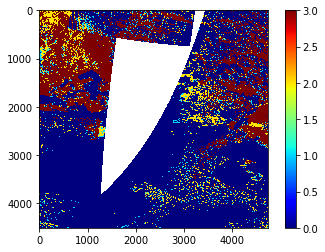

In [76]:
plt.imshow(cloud_mask_array, cmap='jet')
plt.colorbar()

In [77]:
only_clouds = copy.deepcopy(cloud_mask_array)

In [80]:
only_clouds[not_cloud_idx] = np.nan

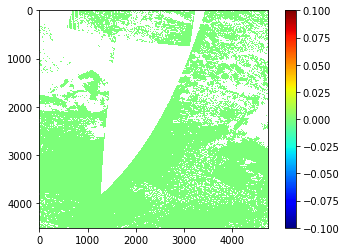

In [81]:
plt.imshow(only_clouds, cmap='jet')
plt.colorbar()

### Model and MOD02 file

##### model load

In [26]:
datadir = "/project2/foster/clouds/output/mod02/m2_02_global_2000_2018_band28_29_31"

In [28]:
step = 100000

In [31]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


#### data load

In [32]:
hdf_datadir = "/project2/chard/clouds/data/MOD02/04"

In [33]:
hdf_filelist=[
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_4.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_5.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_1.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_8.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_9.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_11.hdf'
]

In [35]:
b6_hdf = SD(hdf_filelist[0], SDC.READ)
b7_hdf = SD(hdf_filelist[1], SDC.READ)
b20_hdf = SD(hdf_filelist[2], SDC.READ)
b28_hdf = SD(hdf_filelist[3], SDC.READ)
b29_hdf = SD(hdf_filelist[4], SDC.READ)
b31_hdf = SD(hdf_filelist[5], SDC.READ)

In [36]:
b6_sds = b6_hdf.select("EV_500_Aggr1km_RefSB")
b7_sds = b7_hdf.select("EV_500_Aggr1km_RefSB")
b20_sds = b20_hdf.select("EV_1KM_Emissive")
b28_sds = b28_hdf.select("EV_1KM_Emissive")
b29_sds = b29_hdf.select("EV_1KM_Emissive")
b31_sds = b31_hdf.select("EV_1KM_Emissive")

In [37]:
b6_array, b6 = proc_sds(b6_sds)
b7_array, b7 = proc_sds(b7_sds)
b20_array, b20 = proc_sds(b20_sds)
b28_array, b28 = proc_sds(b28_sds)
b29_array, b29 = proc_sds(b29_sds)
b31_array, b31 = proc_sds(b31_sds)

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


In [38]:
nx, ny = b6_array.shape

In [40]:
d_list = [
    b6_array.reshape(nx,ny,1),
    b7_array.reshape(nx,ny,1),
    b20_array.reshape(nx,ny,1),
    b28_array.reshape(nx,ny,1),
    b29_array.reshape(nx,ny,1),
    b31_array.reshape(nx,ny,1),
]

In [41]:
mod02_img = np.concatenate(d_list, axis=2)

### Select patches with and without cloud-flags

In [42]:
def const_array(patches):
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                patches_list += [patches[i,j]]
                xy_list += [(i,j)]
    return patches_list, xy_list

In [46]:
len(np.argwhere(cloud_mask_array == 0)), len(np.argwhere(cloud_mask_array == 0))/len(cloud_mask_array.flatten())

(12599868, 0.5880170941160153)

In [85]:
def const_clouds_array(patches, clouds_mask, width=128, height=128):
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                if np.any(clouds_mask[i*width:(i+1)*width,j*height:(j+1)*height] == 0):
                    patches_list += [patches[i,j]]
                    xy_list += [(i,j)]
    return patches_list, xy_list

In [48]:
patches = _gen_patches(mod02_img, normalization=False)
patches.shape

(35, 37, 128, 128, 6)

###### patche list with and without clouds mask

In [51]:
patches_list, xy_list = const_array(patches)

In [62]:
cloud_mask_array.shape

(4513, 4748)

In [86]:
clouds_patches_list, clouds_xy_list = const_clouds_array(patches, cloud_mask_array)

In [87]:
len(clouds_patches_list)

983

#### Clustering

In [55]:
def compute_agl(encoder, patches_list,n_cluster = 10):
    encs_list = []
    for i in patches_list:
        encs = encoder.predict(i.reshape(1,128,128,6))
        encs_list += [encs.mean(axis=(1,2))]
    features = np.concatenate(encs_list, axis=0)
    print(features.shape)
    method = AgglomerativeClustering(n_clusters=n_cluster)
    _patches_labels = method.fit_predict(features)
    return _patches_labels

In [56]:
patches_labels = compute_agl(encoder, patches_list)

(1009, 128)


In [88]:
clouds_patches_labels = compute_agl(encoder, clouds_patches_list)

(983, 128)


In [89]:
ix, iy = patches.shape[:2]
img_array = np.zeros((ix,iy)).astype(np.float64)
img_array[:,:] = np.nan
for idx, (x,y) in enumerate(xy_list):
    img_array[x,y] = patches_labels[idx]

In [90]:
ix, iy = patches.shape[:2]
cimg_array = np.zeros((ix,iy)).astype(np.float64)
cimg_array[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cimg_array[x,y] = clouds_patches_labels[idx]

<bound method Figure.tight_layout of <Figure size 720x720 with 4 Axes>>

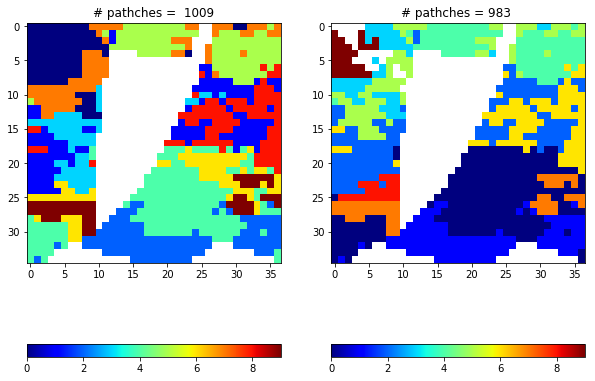

In [96]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
plt.imshow(img_array, cmap='jet')
ax.set_title("# pathches =  %d" % len(xy_list))
plt.colorbar(orientation='horizontal')
ax = plt.subplot(122)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# pathches = %d " % len(clouds_xy_list))
plt.colorbar(orientation='horizontal')
fig.tight_layout

### Strict rule for clouds flag

In [102]:
def dev_const_clouds_array(patches, clouds_mask, width=128, height=128, thres=0.2):
    """
    thres: range 0-1. ratio of clouds within the given patch
    """
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                if np.any(clouds_mask[i*width:(i+1)*width,j*height:(j+1)*height] == 0):
                    tmp = clouds_mask[i*width:(i+1)*width,j*height:(j+1)*height]
                    nclouds = len(np.argwhere(tmp == 0))
                    if nclouds/(width*height) > thres:
                        patches_list += [patches[i,j]]
                        xy_list += [(i,j)]
    return patches_list, xy_list

In [116]:
clouds_patches_list, clouds_xy_list = dev_const_clouds_array(patches, cloud_mask_array, thres=0.4)

In [117]:
len(clouds_patches_list)

780

In [118]:
clouds_patches_labels = compute_agl(encoder, clouds_patches_list)

(780, 128)


In [106]:
### reserve old result
no_thres_cimg_array = cimg_array # first try

In [112]:
thres02_cimg_array = cimg_array

In [115]:
thres03_cimg_array = cimg_array

In [119]:
ix, iy = patches.shape[:2]
cimg_array = np.zeros((ix,iy)).astype(np.float64)
cimg_array[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cimg_array[x,y] = clouds_patches_labels[idx]

<bound method Figure.tight_layout of <Figure size 720x720 with 4 Axes>>

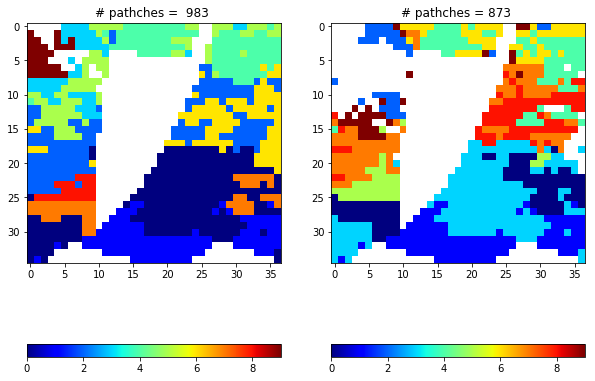

In [108]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
plt.imshow(no_thres_cimg_array, cmap='jet')
ax.set_title("# pathches =  983 ")
plt.colorbar(orientation='horizontal')
ax = plt.subplot(122)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# pathches = %d " % len(clouds_xy_list))
plt.colorbar(orientation='horizontal')
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 720x720 with 4 Axes>>

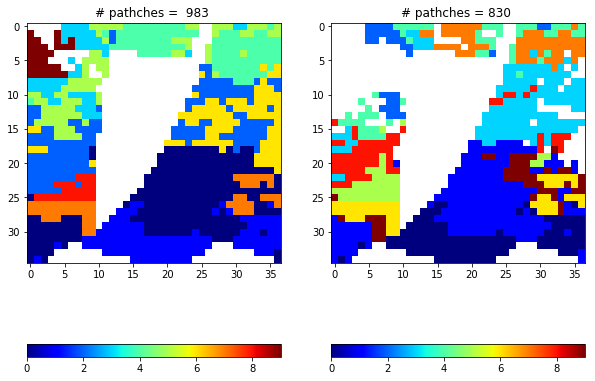

In [114]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
plt.imshow(no_thres_cimg_array, cmap='jet')
ax.set_title("# pathches =  983 ")
plt.colorbar(orientation='horizontal')
ax = plt.subplot(122)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# pathches = %d " % len(clouds_xy_list))
plt.colorbar(orientation='horizontal')
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 720x720 with 4 Axes>>

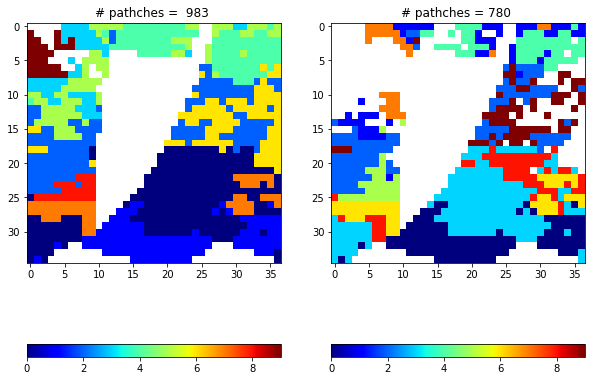

In [120]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
plt.imshow(no_thres_cimg_array, cmap='jet')
ax.set_title("# pathches =  983 ")
plt.colorbar(orientation='horizontal')
ax = plt.subplot(122)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# pathches = %d " % len(clouds_xy_list))
plt.colorbar(orientation='horizontal')
fig.tight_layout